### Use CNN with PyTorch to learn CIFAR-10 (cuda)

In [1]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Hyper parameters
num_epochs = 300
hidden_sizes = [512]
input_channels = 3
num_classes = 10
batch_size = 100
learning_rate = 0.001

In [3]:
torch.cuda.is_available()

True

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Load CIFAR-10 dataset
Can be downloaded by `torchvision.datasets`

https://pytorch.org/docs/stable/torchvision/datasets.html

In [5]:
# CIFAR-10 dataset (32x32 colour images in 10 classes)
# https://www.cs.toronto.edu/~kriz/cifar.html
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='dataset/',
                                           train=True, 
                                           transform=transform,
                                           download=True)

test_dataset = torchvision.datasets.CIFAR10(root='dataset/',
                                          train=False, 
                                          transform=transform,
                                          download=True)

Files already downloaded and verified
Files already downloaded and verified


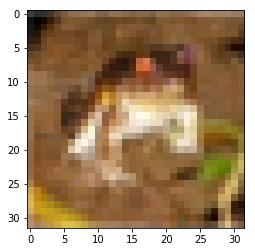

In [6]:
plt.imshow(train_dataset.train_data[0])

In [7]:
print('Original train size:', train_dataset.train_data.shape)
print(len(train_dataset.train_labels))
print('Original test size:', test_dataset.test_data.shape)
print(len(test_dataset.test_labels))

Original train size: (50000, 32, 32, 3)
50000
Original test size: (10000, 32, 32, 3)
10000


In [8]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

### See data dimensions and show images

In [9]:
sample_train_data = iter(train_loader)
images, labels = sample_train_data.next()

In [10]:
print('After DataLoader')
print('Train dimensions:', images.shape)
print(len(labels))

After DataLoader
Train dimensions: torch.Size([100, 3, 32, 32])
100


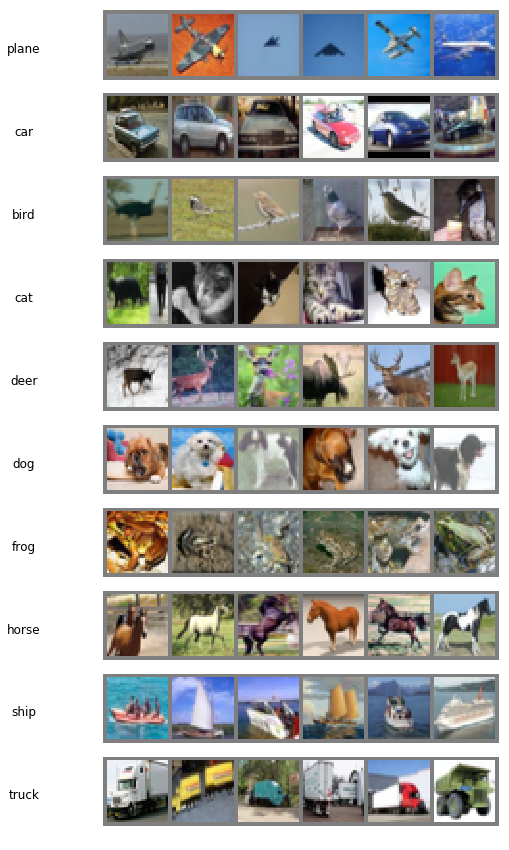

In [11]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

fig = plt.figure(figsize = (15, 15))
def show_photo(img, i, lname):
    img = img / 2 + 0.5
    npimg = img.numpy()
    ax = fig.add_subplot(10, 1, i)
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.axis('off')
    ax.set_title(label=lname, x=-0.2, y=0.3)

for label, lname in enumerate(classes):
    target_label = (labels == label)
    imgs = images[target_label][:6]   
    show_photo(torchvision.utils.make_grid(imgs), label + 1, lname)


### Model vgg:

Vgg16


```
Dimensions:
-> Input(32, 32) 
-> Conv (64, 32, 32) 
-> Conv (64, 32, 32) 
-> MaxPool (64, 16, 16)

-> Conv (128, 16, 16)
-> Conv (128, 16, 16) 
-> MaxPool (128, 8, 8)

-> Conv (256, 8, 8)
-> Conv (256, 8, 8)
-> Conv (256, 8, 8)
-> MaxPool (256, 4, 4)

-> Conv (512, 4, 4)
-> Conv (512, 4, 4) 
-> Conv (512, 4, 4)
-> MaxPool (512, 2, 2)

-> Conv (512, 2, 2)
-> Conv (512, 2, 2) 
-> Conv (512, 2, 2)
-> MaxPool (512, 1, 1)

-> Fully Connected Layer(Logits (10, 1) -> Softmax) -> Labels
```

### Build CNN model

In [12]:
class PytorchDeepConvNetVgg(nn.Module):
    def __init__(self, input_channels, num_classes=10):
        super(PytorchDeepConvNetVgg, self).__init__()

        # Layer 1: conv - relu - conv- relu - pool
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))        
        
        # Layer 2: conv - relu - conv- relu - pool
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        # Layer 3: conv - relu - conv- relu - pool
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        # Layer 4: conv - relu - conv- relu - pool
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        # Layer 5: conv - relu - conv- relu - pool
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.5))


        # Fully Connected 1 (readout)
        # Affine - ReLU - Dropout - Affine - Dropout - Softmax
        self.layer6 = nn.Sequential(
            nn.Linear(512 * 1 * 1, hidden_sizes[0]),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_sizes[0], num_classes))

        # Initialize all parameters using kaiming normalization
        self.init_weights_kaiming()
    
    def init_weights_kaiming(self):
        #Use kaiming normalization to initialize the parameters
        for layer in [self.layer1, self.layer2, self.layer3, self.layer4, self.layer5, self.layer6]:
            for m in layer:
                if type(m) == nn.Conv2d or type(m) == nn.Linear:
                    m.weight = nn.init.kaiming_normal_(m.weight)

    def forward(self, x):

        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        
        out = out.view(out.size(0), -1)
    
        # Linear function (readout)
        out = self.layer6(out)
        
        return out

In [13]:
model = PytorchDeepConvNetVgg(input_channels, num_classes).to(device)
# print(model)

In [14]:
criterion = nn.CrossEntropyLoss()

In [15]:
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay= 0.0005, momentum=0.9, nesterov=True)

# Use Adam as the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Learning rate decay schedule

In [16]:
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=150, gamma=0.1)

### Load pretrained model parameters

In [17]:
# model.load_state_dict(torch.load('model_vgg.ckpt'))

### Train model

In [18]:
iter = 0
accuracies = []
for epoch in range(num_epochs):
    
    # Learning rate decay
    exp_lr_scheduler.step()

    # Print current learning rate
    if epoch % 25 == 0:
        print('learning rate:', optimizer.param_groups[0]['lr'])

    for i, (images, labels) in enumerate(train_loader):
        
        # Load images as Variable
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)
        
        # Clear gradients w.r.t parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        # Calculate Loss: Softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Getting gradients w.r.t paramters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1 

        if iter % 500 == 0:
            correct = 0
            total = 0
            model.eval()
            with torch.no_grad():            
                for images, labels in test_loader:
                    images = Variable(images).to(device)
                    outputs = model(images)

                    _, predicted = torch.max(outputs.data, 1)

                    # Total numer of labels
                    total += labels.size(0)

                    correct += (predicted.to(device) == labels.to(device)).sum()

                accuracy = 100 * correct / total
                accuracies.append(accuracy)
        
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.data.item(), accuracy))


learning rate: 0.001
Iteration: 500. Loss: 1.5968791246414185. Accuracy: 29
Iteration: 1000. Loss: 1.0907267332077026. Accuracy: 52
Iteration: 1500. Loss: 0.9203737378120422. Accuracy: 64
Iteration: 2000. Loss: 0.8311523199081421. Accuracy: 71
Iteration: 2500. Loss: 0.6591851115226746. Accuracy: 75
Iteration: 3000. Loss: 0.619041383266449. Accuracy: 77
Iteration: 3500. Loss: 0.3556014895439148. Accuracy: 79
Iteration: 4000. Loss: 0.30365246534347534. Accuracy: 79
Iteration: 4500. Loss: 0.29499512910842896. Accuracy: 80
Iteration: 5000. Loss: 0.4414757788181305. Accuracy: 80
Iteration: 5500. Loss: 0.20606884360313416. Accuracy: 81
Iteration: 6000. Loss: 0.20232842862606049. Accuracy: 81
Iteration: 6500. Loss: 0.13872148096561432. Accuracy: 81
Iteration: 7000. Loss: 0.10061372816562653. Accuracy: 81
Iteration: 7500. Loss: 0.08932965993881226. Accuracy: 80
Iteration: 8000. Loss: 0.1693299412727356. Accuracy: 80
Iteration: 8500. Loss: 0.1153867170214653. Accuracy: 81
Iteration: 9000. Loss:

Iteration: 70000. Loss: 0.001989173935726285. Accuracy: 83
Iteration: 70500. Loss: 0.01795896328985691. Accuracy: 83
Iteration: 71000. Loss: 0.004080633632838726. Accuracy: 84
Iteration: 71500. Loss: 0.005037997849285603. Accuracy: 83
Iteration: 72000. Loss: 0.000718884461093694. Accuracy: 84
Iteration: 72500. Loss: 0.007474809885025024. Accuracy: 84
Iteration: 73000. Loss: 0.023856276646256447. Accuracy: 83
Iteration: 73500. Loss: 0.023523472249507904. Accuracy: 82
Iteration: 74000. Loss: 0.0011439621448516846. Accuracy: 84
Iteration: 74500. Loss: 0.003987358417361975. Accuracy: 83
Iteration: 75000. Loss: 0.00015447914483956993. Accuracy: 83
learning rate: 0.0001
Iteration: 75500. Loss: 0.0004421621561050415. Accuracy: 84
Iteration: 76000. Loss: 4.863262074650265e-05. Accuracy: 84
Iteration: 76500. Loss: 0.00010532617307035252. Accuracy: 84
Iteration: 77000. Loss: 2.9705763154197484e-05. Accuracy: 84
Iteration: 77500. Loss: 6.602406301681185e-06. Accuracy: 84
Iteration: 78000. Loss: 1

KeyboardInterrupt: 

In [19]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))


Test Accuracy of the model on the 10000 test images: 84.57 %


In [20]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    print('Test Accuracy of the model on the 50000 train images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 50000 train images: 100.0 %


### Test memo:


|dataset size(train/test)|#epoch|      model  |  optimizer | parameters |lr| accuracy(test/train)  |
|-----------------------|-------|--------------|------------|------------|--|------------|
|50000/10000|25|(conv - relu - conv- relu - pool)x2, Linearx1 |torch.optim.Adam|Kaiming He|0.001| 69.43%/ 88.28%|
|50000/10000|25|(conv - relu - conv- relu - pool)x3, linear-relu-dropout-linear-dropout |torch.optim.Adam|Kaiming He|0.001| 70.83%/ 96.01%|
|50000/10000|25|vgg16 |torch.optim.Adam|Kaiming He|0.001| 81.01%/  97.64%|
|50000/10000|50|vgg16 |torch.optim.Adam|Kaiming He|0.001| 83.66%/  99.74%|
|50000/10000|100|vgg16 |torch.optim.Adam|Kaiming He|0.001->(50epoch)0.0001|  83.71%/  100.0%|
|50000/10000|250|vgg16 |torch.optim.Adam|Kaiming He|0.001->(150epoch)0.0001|  84.57%/  100.0%|



In [21]:
# Save the model checkpoint
torch.save(model.state_dict(), 'model_vgg.ckpt')

In [ ]:
# Added dropout layer refers to http://torch.ch/blog/2015/07/30/cifar.html